In [91]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import xgboost
import matplotlib.pyplot as plt
import scikitplot as sckplt
import time
import re
import scipy.stats as stat
from math import sqrt
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import linear_model, tree, neighbors, svm, ensemble

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)

In [77]:
# setting OS directory
os.chdir('C:\\Users\\rckar\\OneDrive\\Documents\\MSBA\\Fall Semester\\6420 Predictive Analytics\\HW3')

In [78]:
# Reading Data
df = pd.read_csv("spambase.data", header=None)

col_names = ["word_freq_make","word_freq_address","word_freq_all",
"word_freq_3d","word_freq_our","word_freq_over","word_freq_remove","word_freq_internet","word_freq_order","word_freq_mail",
"word_freq_receive","word_freq_will","word_freq_people","word_freq_report","word_freq_addresses","word_freq_free","word_freq_business",
"word_freq_email","word_freq_you","word_freq_credit","word_freq_your","word_freq_font","word_freq_000","word_freq_money",
"word_freq_hp","word_freq_hpl","word_freq_george","word_freq_650","word_freq_lab","word_freq_labs","word_freq_telnet",
"word_freq_857","word_freq_data","word_freq_415","word_freq_85","word_freq_technology","word_freq_1999","word_freq_parts",
"word_freq_pm","word_freq_direct","word_freq_cs","word_freq_meeting","word_freq_original","word_freq_project","word_freq_re",
"word_freq_edu","word_freq_table","word_freq_conference","char_freq_;","char_freq_(","char_freq_[","char_freq_!","char_freq_$",
"char_freq_#","capital_run_length_average","capital_run_length_longest","capital_run_length_total","class"
]

df.columns = col_names

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]

df.head(2)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq__,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.0,0.00,...,0.0,0.000,0.0,0.778,0.00,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.0,0.94,...,0.0,0.132,0.0,0.372,0.18,0.048,5.114,101,1028,1


In [79]:
# Data pre-processing

# checking for null values
df.isnull().values.any()

False

In [80]:
# Factorizing diagnosis as diagnosis class for modelling purpose
# df['spam_class'],class_names = pd.factorize(df['class'], sort=True)
# print(class_names)
# df[['class','spam_class']].head(n=2)

# Checking for class imbalance
# df['spam_class'].value_counts()

In [81]:
# Selecting required columns
X_df = df.iloc[:,0:57]
y_df = df.iloc[:,57]

In [82]:
y_df.head(2)

0    1
1    1
Name: class, dtype: int64

##### Creating the Train and Test split

In [83]:
X_train, X_test_holdout, y_train, y_test_holdout = train_test_split(X_df, y_df, test_size=0.25, random_state=42)

##### Normalizing Data

In [84]:
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)

X_test_scaled = scaler.fit_transform(X_test_holdout)
X_test_scaled = pd.DataFrame(X_test_scaled)

In [85]:
cost = [[0,10],[1,0]]
def calc_cost(matrix,cost):
    return ((matrix*cost).sum())

### Checking effect of Normalizing data using KNN and Logistic

In [11]:
print("non-normalized data")
print(" ")

print("Logistic Regression")
# create logistic regression object 
clf_logistic = linear_model.LogisticRegression()

# Hyperparameter tuning
param_set ={'penalty' : ["l1","l2"], 'C':np.arange(0.2,1,0.1), 'class_weight': [None, 'balanced']}
grid_logistic = GridSearchCV(clf_logistic, param_grid = param_set, cv=5, scoring='accuracy')
grid_logistic.fit(X_train,y_train)

clf_logistic_best = grid_logistic.best_estimator_
scores = cross_val_score(clf_logistic_best, X_train, y_train, cv=5)
print("Mean Accuracy and variance on training data: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf_logistic_best.fit(X_train,y_train)
y_pred = clf_logistic_best.predict(X_test_holdout)
print("Accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")

# KNN
print(" ")
print("KNN")
clf_knn = neighbors.KNeighborsClassifier()

#Hyper Parameter tuning
param_set ={'n_neighbors': list(range(4,20)), 'weights': ["uniform", "distance"]}
grid_knn = GridSearchCV(clf_knn, param_grid = param_set, cv=5, scoring='accuracy')
grid_knn.fit(X_train,y_train)

clf_knn_best = grid_knn.best_estimator_
scores = cross_val_score(clf_knn_best, X_train, y_train, cv=10)
print("Mean Accuracy and variance on training data: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf_knn_best.fit(X_train,y_train)
y_pred = clf_knn_best.predict(X_test_holdout)
print("Accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")

#Decision Tree
print(" ")
print("Decision Tree")

clf_DTree = tree.DecisionTreeClassifier()

# Hyper parameter tuning using GridSearch
param_set ={'max_depth': range(3,20), 'min_samples_split' : range(3,15), 'criterion' : ["gini", "entropy"]}
grid_DTree = GridSearchCV(clf_DTree, param_grid = param_set, cv=5, scoring='accuracy')
grid_DTree.fit(X_train,y_train)

clf_Dtree_best = grid_DTree.best_estimator_
scores = cross_val_score(clf_Dtree_best, X_train, y_train, cv=10)
print("Mean Accuracy and variance on training data: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf_Dtree_best.fit(X_train,y_train)
y_pred = clf_Dtree_best.predict(X_test_holdout)
print("Accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")

print(" ")
print(" ")
print("Normalized data")
print(" ")

print("Logistic Regression")
# create logistic regression object 
clf_logistic = linear_model.LogisticRegression()

# Hyperparameter tuning
param_set ={'penalty' : ["l1","l2"], 'C':np.arange(0.2,1,0.1), 'class_weight': [None, 'balanced']}
grid_logistic = GridSearchCV(clf_logistic, param_grid = param_set, cv=5, scoring='accuracy')
grid_logistic.fit(X_train_scaled,y_train)

clf_logistic_best = grid_logistic.best_estimator_
scores = cross_val_score(clf_logistic_best, X_train_scaled, y_train, cv=5)
print("Mean Accuracy and variance on training data: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf_logistic_best.fit(X_train_scaled,y_train)
y_pred = clf_logistic_best.predict(X_test_scaled)
print("Accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")

# KNN
print(" ")
print("KNN")
clf_knn = neighbors.KNeighborsClassifier()

#Hyper Parameter tuning
param_set ={'n_neighbors': list(range(4,20)), 'weights': ["uniform", "distance"]}
grid_knn = GridSearchCV(clf_knn, param_grid = param_set, cv=5, scoring='accuracy')
grid_knn.fit(X_train_scaled,y_train)

clf_knn_best = grid_knn.best_estimator_
scores = cross_val_score(clf_knn_best, X_train_scaled, y_train, cv=10)
print("Mean Accuracy and variance on training data: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf_knn_best.fit(X_train_scaled,y_train)
y_pred = clf_knn_best.predict(X_test_scaled)
print("Accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")

#Decision Tree
print(" ")
print("Decision Tree")

clf_DTree = tree.DecisionTreeClassifier()

# Hyper parameter tuning using GridSearch
param_set ={'max_depth': range(3,20), 'min_samples_split' : range(3,15), 'criterion' : ["gini", "entropy"]}
grid_DTree = GridSearchCV(clf_DTree, param_grid = param_set, cv=5, scoring='accuracy')
grid_DTree.fit(X_train_scaled,y_train)

clf_Dtree_best = grid_DTree.best_estimator_
scores = cross_val_score(clf_Dtree_best, X_train_scaled, y_train, cv=10)
print("Mean Accuracy and variance on training data: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf_Dtree_best.fit(X_train_scaled,y_train)
y_pred = clf_Dtree_best.predict(X_test_scaled)
print("Accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")

non-normalized data
 
Logistic Regression
Mean Accuracy and variance on training data: 0.93 (+/- 0.01)
Accuracy on test data is  92.88 %
 
KNN
Mean Accuracy and variance on training data: 0.82 (+/- 0.04)
Accuracy on test data is  80.02 %
 
Decision Tree
Mean Accuracy and variance on training data: 0.92 (+/- 0.03)
Accuracy on test data is  91.83 %
 
 
Normalized data
 
Logistic Regression
Mean Accuracy and variance on training data: 0.92 (+/- 0.02)
Accuracy on test data is  91.83 %
 
KNN
Mean Accuracy and variance on training data: 0.91 (+/- 0.03)
Accuracy on test data is  89.75 %
 
Decision Tree
Mean Accuracy and variance on training data: 0.92 (+/- 0.03)
Accuracy on test data is  90.27 %


Hence Normalization for Distance based models
and non-normalized data for other models

## Considering only accuracy

## Logistic Regression

In [12]:
# create logistic regression object 
clf_logistic = linear_model.LogisticRegression()

# Hyperparameter tuning
param_set ={'penalty' : ["l1","l2"], 'C':np.arange(0.2,1,0.1), 'class_weight': [None, 'balanced']}
grid_logistic = GridSearchCV(clf_logistic, param_grid = param_set, cv=5, scoring='accuracy')
grid_logistic.fit(X_train,y_train)

# examine the best model
print("Best score achieved across all parameters: ", grid_logistic.best_score_)

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_logistic.best_params_)

print(" ")
print("Best estimator")
print (grid_logistic.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_logistic_best = grid_logistic.best_estimator_
scores = cross_val_score(clf_logistic_best, X_train, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#prediction on test data
clf_logistic_best.fit(X_train,y_train)
print(" ")
y_pred = clf_logistic_best.predict(X_test_holdout)
print("Logistic : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("Logistic : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("Logistic : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Best score achieved across all parameters:  0.9266666666666666
 
Best parameters
{'C': 0.8000000000000003, 'class_weight': None, 'penalty': 'l1'}
 
Best estimator
LogisticRegression(C=0.8000000000000003, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
 
cross-validation results
Below are the scores for each model run
[0.92474674 0.9146165  0.93188406 0.93613933 0.92597968]
 
Mean Accuracy and variance: 0.93 (+/- 0.01)
 
Logistic : accuracy on test data is  92.88 %
 
Logistic : Confusion Matrix
 
[[652  24]
 [ 58 417]]
 
Logistic : Classification Report
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       676
           1       0.95      0.88      0.91       475

   micro avg       0.93      0.93      0.93      1151
   macro avg       0.93      0.92

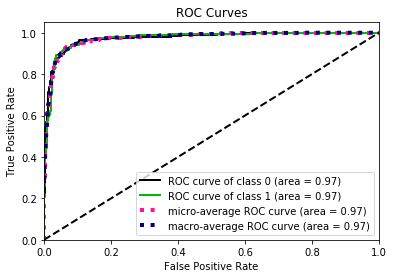

In [15]:
y_probas =  clf_logistic_best.predict_proba(X_test_holdout) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

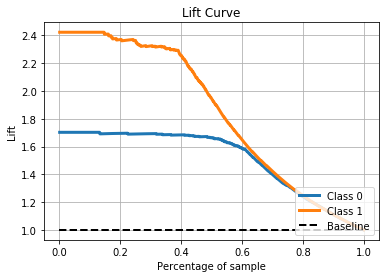

In [16]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## KNN

In [29]:
clf_knn = neighbors.KNeighborsClassifier()

#Hyper Parameter tuning
param_set ={'n_neighbors': list(range(4,20)), 'weights': ["uniform", "distance"]}
grid_knn = GridSearchCV(clf_knn, param_grid = param_set, cv=5, scoring='accuracy')
grid_knn.fit(X_train_scaled,y_train)

# examine the best model
print("Best score achieved across all parameters: ", grid_knn.best_score_)

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_knn.best_params_)

print(" ")
print("Best estimator")
print (grid_knn.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_knn_best = grid_knn.best_estimator_
scores = cross_val_score(clf_knn_best, X_train_scaled, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#prediction on test data
clf_knn_best.fit(X_train_scaled,y_train)
print(" ")
y_pred = clf_knn_best.predict(X_test_scaled)
print("KNN : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("KNN : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("KNN : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Best score achieved across all parameters:  0.9113043478260869
 
Best parameters
{'n_neighbors': 8, 'weights': 'distance'}
 
Best estimator
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=8, p=2,
           weights='distance')
 
cross-validation results
Below are the scores for each model run
[0.9146165  0.90593343 0.90724638 0.92307692 0.90566038]
 
Mean Accuracy and variance: 0.91 (+/- 0.01)
 
KNN : accuracy on test data is  89.75 %
 
KNN : Confusion Matrix
 
[[614  62]
 [ 56 419]]
 
KNN : Classification Report
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       676
           1       0.87      0.88      0.88       475

   micro avg       0.90      0.90      0.90      1151
   macro avg       0.89      0.90      0.89      1151
weighted avg       0.90      0.90      0.90      1151

Average Misclassification cost on test data is  676


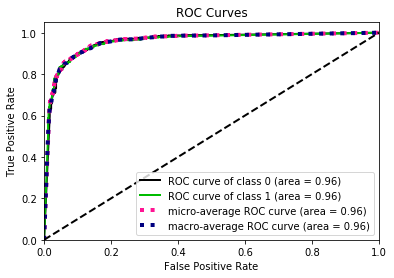

In [30]:
y_probas =  clf_knn_best.predict_proba(X_test_scaled) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

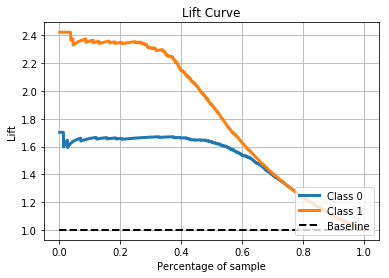

In [31]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## Decision Tree

In [20]:
clf_DTree = tree.DecisionTreeClassifier()

# Hyper parameter tuning using GridSearch
param_set ={'max_depth': range(3,20), 'min_samples_split' : range(3,15), 'criterion' : ["gini", "entropy"]}
grid_DTree = GridSearchCV(clf_DTree, param_grid = param_set, cv=5, scoring='accuracy')
grid_DTree.fit(X_train_scaled,y_train)

# examine the best model
print("Best score achieved across all parameters: ", grid_DTree.best_score_)

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_DTree.best_params_)

print(" ")
print("Best estimator")
print (grid_DTree.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_Dtree_best = grid_DTree.best_estimator_
scores = cross_val_score(clf_Dtree_best, X_train, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#prediction on test data
clf_Dtree_best.fit(X_train,y_train)
print(" ")
y_pred = clf_Dtree_best.predict(X_test_holdout)
print("Decision Tree : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("Decision Tree : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("Decision Tree : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Best score achieved across all parameters:  0.9281159420289855
 
Best parameters
{'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 5}
 
Best estimator
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
 
cross-validation results
Below are the scores for each model run
[0.94211288 0.91172214 0.90869565 0.92888244 0.92307692]
 
Mean Accuracy and variance: 0.92 (+/- 0.02)
 
Decision Tree : accuracy on test data is  91.83 %
 
Decision Tree : Confusion Matrix
 
[[649  27]
 [ 67 408]]
 
Decision Tree : Classification Report
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       676
           1       0.94      0.86      0.90       475


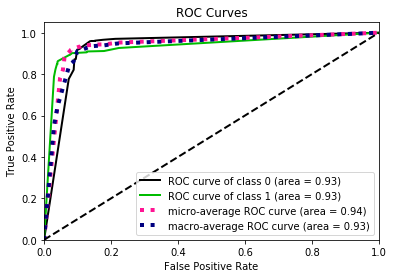

In [21]:
y_probas =  clf_Dtree_best.predict_proba(X_test_holdout) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

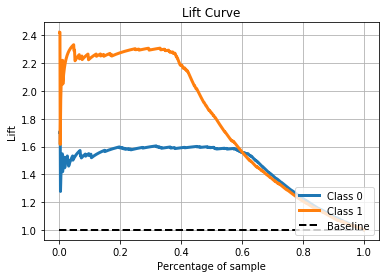

In [22]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## Support Vector classification

In [23]:
clf_SVC = svm.SVC(probability=True)

# Hyper parameter tuning using GridSearch
param_set = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1,2,3,4,5,10,100]},
                    {'kernel': ['linear'], 'C': [1,2,3,5,10,100]}]
grid_SVC = GridSearchCV(clf_SVC, param_grid = param_set, cv=5, scoring='accuracy')
grid_SVC.fit(X_train_scaled,y_train)

# examine the best model
print("Best score achieved across all parameters: ", grid_SVC.best_score_)

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_SVC.best_params_)

print(" ")
print("Best estimator")
print (grid_SVC.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_SVC_best = grid_SVC.best_estimator_
scores = cross_val_score(clf_SVC_best, X_train_scaled, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#prediction on test data
clf_SVC_best.fit(X_train_scaled,y_train)
print(" ")
y_pred = clf_SVC_best.predict(X_test_scaled)
print("SVC : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("SVC : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("SVC : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Best score achieved across all parameters:  0.928695652173913
 
Best parameters
{'C': 100, 'kernel': 'linear'}
 
Best estimator
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
 
cross-validation results
Below are the scores for each model run
[0.92040521 0.9146165  0.93333333 0.94629898 0.92888244]
 
Mean Accuracy and variance: 0.93 (+/- 0.02)
 
SVC : accuracy on test data is  92.27 %
 
SVC : Confusion Matrix
 
[[616  60]
 [ 29 446]]
 
SVC : Classification Report
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       676
           1       0.88      0.94      0.91       475

   micro avg       0.92      0.92      0.92      1151
   macro avg       0.92      0.93      0.92      1151
weighted avg       0.92      0.92      0.92      1151

Average Misclas

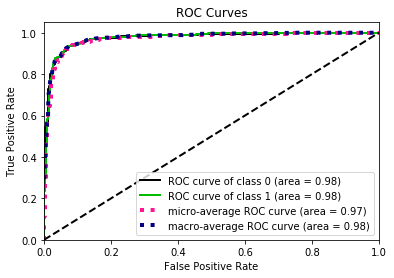

In [26]:
y_probas =  clf_SVC_best.predict_proba(X_test_scaled) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

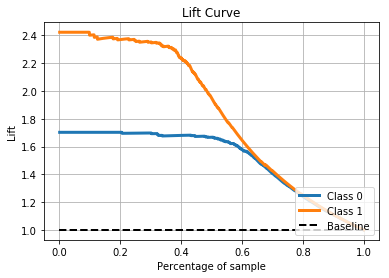

In [27]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## Ensemble model : Random Forest

In [32]:
start = time.process_time()
RF = ensemble.RandomForestClassifier()

# Hyper parameter tuning using GridSearch
param_set ={'max_depth': [3,10,20],
            'min_samples_split' :[4, 5,10],
            'n_estimators': [100, 250,500],
            'bootstrap':[True, False] ,
            'max_features':['auto', 'sqrt'],
            'n_jobs': [-1]
           }
grid_RF = GridSearchCV(RF, param_grid = param_set, cv=5, scoring='accuracy')
grid_RF.fit(X_train,y_train)

# examine the best model
print("Best score achieved across all parameters: ", grid_RF.best_score_)

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_RF.best_params_)

print(" ")
print("Best estimator")
print (grid_RF.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_RF_best = grid_RF.best_estimator_
scores = cross_val_score(clf_RF_best, X_train, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Check performance on test data
clf_RF_best.fit(X_train,y_train)
print(" ")
y_pred = clf_RF_best.predict(X_test_holdout)
print("Random Forest : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("Random Forest : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("Random Forest : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

print(" ")
print('Time Taken = ', time.process_time() - start)

Best score achieved across all parameters:  0.9515942028985507
 
Best parameters
{'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100, 'n_jobs': -1}
 
Best estimator
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
 
cross-validation results
Below are the scores for each model run
[0.9536903  0.93342981 0.94927536 0.95645864 0.96081277]
 
Mean Accuracy and variance: 0.95 (+/- 0.02)
 
Random Forest : accuracy on test data is  95.74 %
 
Random Forest : Confusion Matrix
 
[[665  11]
 [ 38 437]]
 
Random Forest : Classification Report
              precision    recall  f1

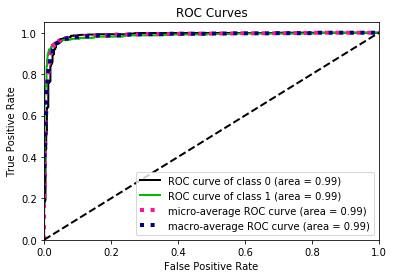

In [33]:
y_probas =  clf_RF_best.predict_proba(X_test_holdout) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

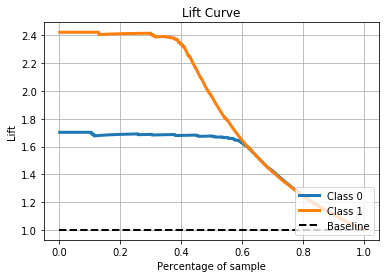

In [34]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## Ensemble model : XGBoost

In [92]:
start = time.process_time()
XGB = xgboost.XGBClassifier(nthreads=-1)

a = stat.beta(10, 1)

# Hyper parameter tuning using GridSearch
param_set ={"n_estimators": stat.randint(3, 40),
            "max_depth": stat.randint(3, 40),
            "learning_rate": stat.uniform(0.05, 0.4),
            "colsample_bytree": a,
            "subsample": a,
            "gamma": st.uniform(0, 10),
            'n_jobs':[-1]
           }

grid_XGB = RandomizedSearchCV(XGB, param_set, cv=5, scoring='accuracy')
grid_XGB.fit(X_train,y_train)

# examine the best model
print("Best score achieved across all parameters: ", abs(grid_XGB.best_score_))

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_XGB.best_params_)

print(" ")
print("Best estimator")
print (grid_XGB.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_XGB_best = grid_XGB.best_estimator_
scores = cross_val_score(clf_XGB_best, X_train, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Check performance on test data
clf_XGB_best.fit(X_train,y_train)
print(" ")
y_pred = clf_XGB_best.predict(X_test_holdout)
print("XGBoost : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("XGBoost : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("XGBoost : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

print('Time Taken = ', time.process_time() - start)

Best score achieved across all parameters:  0.9478260869565217
 
Best parameters
{'colsample_bytree': 0.7616260101598761, 'gamma': 0.04285167992900463, 'learning_rate': 0.4459090746140388, 'max_depth': 20, 'n_estimators': 29, 'n_jobs': -1, 'subsample': 0.5865029452751788}
 
Best estimator
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7616260101598761,
       gamma=0.04285167992900463, learning_rate=0.4459090746140388,
       max_delta_step=0, max_depth=20, min_child_weight=1, missing=None,
       n_estimators=29, n_jobs=-1, nthread=None, nthreads=-1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=0.5865029452751788, verbosity=1)
 
cross-validation results
Below are the scores for each model run
[0.95079595 0.9406657  0.94202899 0.95065312 0.95500726]
 
Mean Accuracy and variance: 0.95 (+/- 0.01)
 
XGBoost : accuracy on 

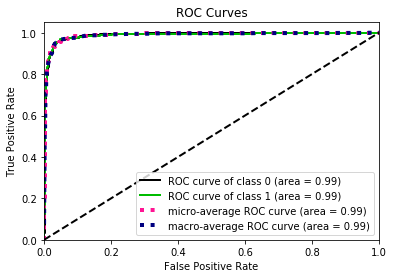

In [93]:
y_probas =  clf_XGB_best.predict_proba(X_test_holdout) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

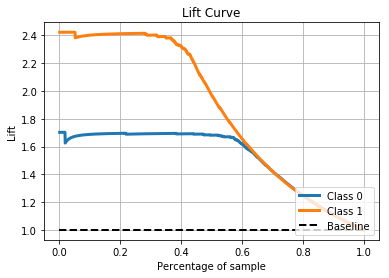

In [94]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## Neural Network

##### Shallow network

In [37]:
NN = Sequential()
# n_cols = x_train.shape[1]
NN.add(Dense(114, activation = 'relu', input_dim=57))
NN.add(Dense(1,activation = 'sigmoid'))
NN.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

NN.fit(X_train,y_train,batch_size=40,epochs=100)

accuracy = NN.evaluate(X_test_holdout, y_test_holdout)
print(accuracy)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
3450/3450 [==============================] - 0s 105us/step - loss: 1.2996 - accuracy: 0.7017
Epoch 2/100
3450/3450 [==============================] - 0s 27us/step - loss: 0.4152 - accuracy: 0.8597
Epoch 3/100
3450/3450 [==============================] - 0s 27us/step - loss: 0.5310 - accuracy: 0.8472
Epoch 4/100
3450/3450 [==============================] - 0s 49us/step - loss: 0.3978 - accuracy: 0.8736
Epoch 5/100
3450/3450 [==============================] - 0s 56us/step - loss: 0.2874 - accuracy: 0.8988
Epoch 6/100
3450/3450 [==============================] - 0s 54us/step - loss: 0.4576 - accuracy: 0.8768
Epoch 7/100
3450/3450 [==============================] - 0s 38us/step - loss: 0.3542 - accuracy: 0.8939
Epoch 8/100
3450/3450 [==============================] - 0s 49us/step - loss: 0.3784 - accuracy: 0.8884
Epoch 9/100
3450/3450 [========================

3450/3450 [==============================] - 0s 35us/step - loss: 0.1780 - accuracy: 0.9438
Epoch 74/100
3450/3450 [==============================] - 0s 37us/step - loss: 0.2354 - accuracy: 0.9371
Epoch 75/100
3450/3450 [==============================] - 0s 39us/step - loss: 0.2245 - accuracy: 0.9414
Epoch 76/100
3450/3450 [==============================] - 0s 36us/step - loss: 0.2603 - accuracy: 0.9342
Epoch 77/100
3450/3450 [==============================] - 0s 36us/step - loss: 0.3707 - accuracy: 0.9214
Epoch 78/100
3450/3450 [==============================] - 0s 40us/step - loss: 0.2515 - accuracy: 0.9359
Epoch 79/100
3450/3450 [==============================] - 0s 43us/step - loss: 0.2532 - accuracy: 0.9359
Epoch 80/100
3450/3450 [==============================] - 0s 39us/step - loss: 0.1734 - accuracy: 0.9461
Epoch 81/100
3450/3450 [==============================] - 0s 45us/step - loss: 0.1549 - accuracy: 0.9504
Epoch 82/100
3450/3450 [==============================] - 0s 51us/st

In [38]:
# Predicting the Test set results
y_pred = NN.predict(X_test_holdout)
y_pred = (y_pred > 0.5)

print("Neural Network : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("Neural Network : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("Neural Network : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Neural Network : accuracy on test data is  94.18 %
 
Neural Network : Confusion Matrix
 
[[643  33]
 [ 34 441]]
 
Neural Network : Classification Report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       676
           1       0.93      0.93      0.93       475

   micro avg       0.94      0.94      0.94      1151
   macro avg       0.94      0.94      0.94      1151
weighted avg       0.94      0.94      0.94      1151

Average Misclassification cost on test data is  364


##### Medium Deep Network

In [39]:
NN = Sequential()
# n_cols = x_train.shape[1]
NN.add(Dense(57, activation = 'relu', input_dim=57))
NN.add(Dense(57, activation = 'relu'))
NN.add(Dense(1,activation = 'sigmoid'))
NN.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

NN.fit(X_train,y_train,batch_size=40,epochs=100)

accuracy = NN.evaluate(X_test_holdout, y_test_holdout)
print(accuracy)

Epoch 1/100
3450/3450 [==============================] - 0s 124us/step - loss: 1.1027 - accuracy: 0.6803
Epoch 2/100
3450/3450 [==============================] - 0s 31us/step - loss: 0.6374 - accuracy: 0.8006
Epoch 3/100
3450/3450 [==============================] - 0s 32us/step - loss: 0.3568 - accuracy: 0.8791
Epoch 4/100
3450/3450 [==============================] - 0s 48us/step - loss: 0.3662 - accuracy: 0.8820
Epoch 5/100
3450/3450 [==============================] - 0s 60us/step - loss: 0.3472 - accuracy: 0.8864
Epoch 6/100
3450/3450 [==============================] - 0s 54us/step - loss: 0.4483 - accuracy: 0.8672
Epoch 7/100
3450/3450 [==============================] - 0s 29us/step - loss: 0.3905 - accuracy: 0.8728
Epoch 8/100
3450/3450 [==============================] - 0s 59us/step - loss: 0.3823 - accuracy: 0.8867
Epoch 9/100
3450/3450 [==============================] - 0s 63us/step - loss: 0.4660 - accuracy: 0.8757
Epoch 10/100
3450/3450 [==============================] - 0s 42

3450/3450 [==============================] - 0s 56us/step - loss: 0.2008 - accuracy: 0.9406
Epoch 79/100
3450/3450 [==============================] - 0s 60us/step - loss: 0.2593 - accuracy: 0.9342
Epoch 80/100
3450/3450 [==============================] - 0s 66us/step - loss: 0.2223 - accuracy: 0.9400
Epoch 81/100
3450/3450 [==============================] - 0s 42us/step - loss: 0.1541 - accuracy: 0.9493
Epoch 82/100
3450/3450 [==============================] - 0s 51us/step - loss: 0.1614 - accuracy: 0.9472
Epoch 83/100
3450/3450 [==============================] - 0s 51us/step - loss: 0.1543 - accuracy: 0.9525
Epoch 84/100
3450/3450 [==============================] - 0s 42us/step - loss: 0.1769 - accuracy: 0.9472
Epoch 85/100
3450/3450 [==============================] - 0s 44us/step - loss: 0.1576 - accuracy: 0.9516
Epoch 86/100
3450/3450 [==============================] - 0s 59us/step - loss: 0.1403 - accuracy: 0.9542
Epoch 87/100
3450/3450 [==============================] - 0s 56us/st

In [41]:
# Predicting the Test set results
y_pred = NN.predict(X_test_holdout)
y_pred = (y_pred > 0.5)

print("Neural Network : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("Neural Network : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("Neural Network : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Neural Network : accuracy on test data is  92.44 %
 
Neural Network : Confusion Matrix
 
[[617  59]
 [ 28 447]]
 
Neural Network : Classification Report
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       676
           1       0.88      0.94      0.91       475

   micro avg       0.92      0.92      0.92      1151
   macro avg       0.92      0.93      0.92      1151
weighted avg       0.93      0.92      0.92      1151

Average Misclassification cost on test data is  618


##### Deep Network

In [42]:
NN = Sequential()
# n_cols = x_train.shape[1]
NN.add(Dense(25, activation = 'relu', input_dim=57))
NN.add(Dense(25, activation = 'relu'))
NN.add(Dense(25, activation = 'relu'))
NN.add(Dense(1,activation = 'sigmoid'))
NN.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

NN.fit(X_train,y_train,batch_size=40,epochs=100)

accuracy = NN.evaluate(X_test_holdout, y_test_holdout)
print(accuracy)

Epoch 1/100
3450/3450 [==============================] - 1s 151us/step - loss: 1.0754 - accuracy: 0.6612
Epoch 2/100
3450/3450 [==============================] - 0s 57us/step - loss: 0.4460 - accuracy: 0.8461
Epoch 3/100
3450/3450 [==============================] - 0s 62us/step - loss: 0.3740 - accuracy: 0.8670
Epoch 4/100
3450/3450 [==============================] - 0s 36us/step - loss: 0.3594 - accuracy: 0.8774
Epoch 5/100
3450/3450 [==============================] - 0s 38us/step - loss: 0.3459 - accuracy: 0.8820
Epoch 6/100
3450/3450 [==============================] - 0s 51us/step - loss: 0.3258 - accuracy: 0.8884
Epoch 7/100
3450/3450 [==============================] - 0s 63us/step - loss: 0.3120 - accuracy: 0.8933
Epoch 8/100
3450/3450 [==============================] - 0s 62us/step - loss: 0.3188 - accuracy: 0.9000
Epoch 9/100
3450/3450 [==============================] - 0s 51us/step - loss: 0.4893 - accuracy: 0.8635
Epoch 10/100
3450/3450 [==============================] - 0s 59

3450/3450 [==============================] - 0s 62us/step - loss: 0.1355 - accuracy: 0.9510
Epoch 80/100
3450/3450 [==============================] - 0s 55us/step - loss: 0.1563 - accuracy: 0.9496
Epoch 81/100
3450/3450 [==============================] - 0s 42us/step - loss: 0.1465 - accuracy: 0.9496
Epoch 82/100
3450/3450 [==============================] - 0s 51us/step - loss: 0.1318 - accuracy: 0.9490
Epoch 83/100
3450/3450 [==============================] - 0s 63us/step - loss: 0.1282 - accuracy: 0.9513
Epoch 84/100
3450/3450 [==============================] - 0s 62us/step - loss: 0.1346 - accuracy: 0.9528
Epoch 85/100
3450/3450 [==============================] - 0s 61us/step - loss: 0.1422 - accuracy: 0.9528
Epoch 86/100
3450/3450 [==============================] - 0s 59us/step - loss: 0.1362 - accuracy: 0.9504
Epoch 87/100
3450/3450 [==============================] - 0s 51us/step - loss: 0.1175 - accuracy: 0.9574
Epoch 88/100
3450/3450 [==============================] - 0s 65us/st

In [43]:
# Predicting the Test set results
y_pred = NN.predict(X_test_holdout)
y_pred = (y_pred > 0.5)

print("Neural Network : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("Neural Network : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("Neural Network : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Neural Network : accuracy on test data is  94.44 %
 
Neural Network : Confusion Matrix
 
[[653  23]
 [ 41 434]]
 
Neural Network : Classification Report
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       676
           1       0.95      0.91      0.93       475

   micro avg       0.94      0.94      0.94      1151
   macro avg       0.95      0.94      0.94      1151
weighted avg       0.94      0.94      0.94      1151

Average Misclassification cost on test data is  271


## Considering cost of misclassification error

Model and it's hyperparameter to be optimized to reduce the average misclassification error. 2 ways - Precision and custom cost function

## Logistic Regression

In [44]:
# create logistic regression object 
clf_logistic = linear_model.LogisticRegression()

# Hyperparameter tuning
param_set ={'penalty' : ["l1","l2"], 'C':np.arange(0.2,1,0.1), 'class_weight': [None, 'balanced']}
grid_logistic = GridSearchCV(clf_logistic, param_grid = param_set, cv=5, scoring='precision')
grid_logistic.fit(X_train,y_train)

# examine the best model
print("Best score achieved across all parameters: ", grid_logistic.best_score_)

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_logistic.best_params_)

print(" ")
print("Best estimator")
print (grid_logistic.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_logistic_best = grid_logistic.best_estimator_
scores = cross_val_score(clf_logistic_best, X_train, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#prediction on test data
clf_logistic_best.fit(X_train,y_train)
print(" ")
y_pred = clf_logistic_best.predict(X_test_holdout)
print("Logistic : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("Logistic : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("Logistic : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Best score achieved across all parameters:  0.9252962761556569
 
Best parameters
{'C': 0.8000000000000003, 'class_weight': None, 'penalty': 'l1'}
 
Best estimator
LogisticRegression(C=0.8000000000000003, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
 
cross-validation results
Below are the scores for each model run
[0.92474674 0.9146165  0.93188406 0.93613933 0.92597968]
 
Mean Accuracy and variance: 0.93 (+/- 0.01)
 
Logistic : accuracy on test data is  92.88 %
 
Logistic : Confusion Matrix
 
[[652  24]
 [ 58 417]]
 
Logistic : Classification Report
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       676
           1       0.95      0.88      0.91       475

   micro avg       0.93      0.93      0.93      1151
   macro avg       0.93      0.92

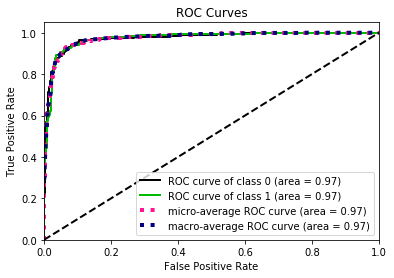

In [45]:
y_probas =  clf_logistic_best.predict_proba(X_test_holdout) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

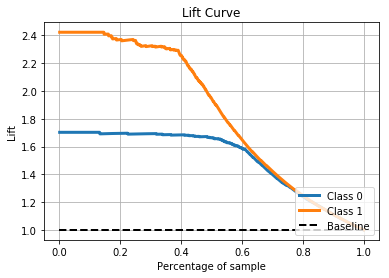

In [46]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## KNN

In [47]:
clf_knn = neighbors.KNeighborsClassifier()

#Hyper Parameter tuning
param_set ={'n_neighbors': list(range(4,20)), 'weights': ["uniform", "distance"]}
grid_knn = GridSearchCV(clf_knn, param_grid = param_set, cv=5, scoring='precision')
grid_knn.fit(X_train_scaled,y_train)

# examine the best model
print("Best score achieved across all parameters: ", grid_knn.best_score_)

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_knn.best_params_)

print(" ")
print("Best estimator")
print (grid_knn.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_knn_best = grid_knn.best_estimator_
scores = cross_val_score(clf_knn_best, X_train_scaled, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#prediction on test data
clf_knn_best.fit(X_train_scaled,y_train)
print(" ")
y_pred = clf_knn_best.predict(X_test_scaled)
print("KNN : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("KNN : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("KNN : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Best score achieved across all parameters:  0.9121393383371263
 
Best parameters
{'n_neighbors': 8, 'weights': 'uniform'}
 
Best estimator
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=8, p=2,
           weights='uniform')
 
cross-validation results
Below are the scores for each model run
[0.89725036 0.88422576 0.88405797 0.90275762 0.8838897 ]
 
Mean Accuracy and variance: 0.89 (+/- 0.02)
 
KNN : accuracy on test data is  89.75 %
 
KNN : Confusion Matrix
 
[[626  50]
 [ 68 407]]
 
KNN : Classification Report
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       676
           1       0.89      0.86      0.87       475

   micro avg       0.90      0.90      0.90      1151
   macro avg       0.90      0.89      0.89      1151
weighted avg       0.90      0.90      0.90      1151

Average Misclassification cost on test data is  568


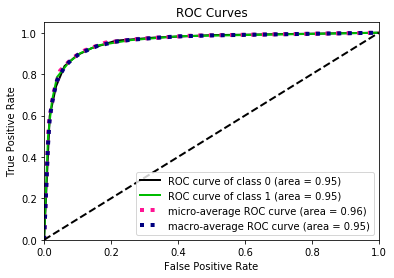

In [50]:
y_probas =  clf_knn_best.predict_proba(X_test_scaled) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

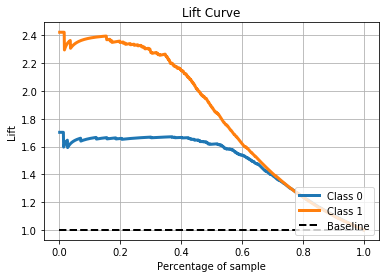

In [51]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## Decision Tree

In [52]:
clf_DTree = tree.DecisionTreeClassifier()

# Hyper parameter tuning using GridSearch
param_set ={'max_depth': range(3,20), 'min_samples_split' : range(3,15), 'criterion' : ["gini", "entropy"]}
grid_DTree = GridSearchCV(clf_DTree, param_grid = param_set, cv=5, scoring='precision')
grid_DTree.fit(X_train_scaled,y_train)

# examine the best model
print("Best score achieved across all parameters: ", grid_DTree.best_score_)

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_DTree.best_params_)

print(" ")
print("Best estimator")
print (grid_DTree.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_Dtree_best = grid_DTree.best_estimator_
scores = cross_val_score(clf_Dtree_best, X_train, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#prediction on test data
clf_Dtree_best.fit(X_train,y_train)
print(" ")
y_pred = clf_Dtree_best.predict(X_test_holdout)
print("Decision Tree : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("Decision Tree : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("Decision Tree : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Best score achieved across all parameters:  0.9311625855043024
 
Best parameters
{'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 6}
 
Best estimator
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
 
cross-validation results
Below are the scores for each model run
[0.90448625 0.88856729 0.90724638 0.91727141 0.90275762]
 
Mean Accuracy and variance: 0.90 (+/- 0.02)
 
Decision Tree : accuracy on test data is  89.75 %
 
Decision Tree : Confusion Matrix
 
[[654  22]
 [ 96 379]]
 
Decision Tree : Classification Report
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       676
           1       0.95      0.80      0.87       475

   micr

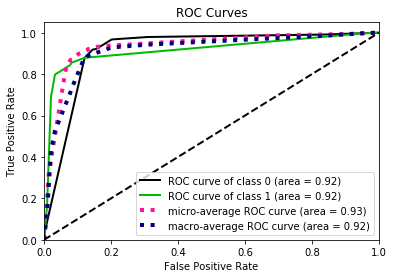

In [53]:
y_probas =  clf_Dtree_best.predict_proba(X_test_holdout) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

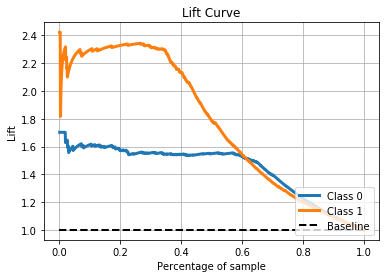

In [55]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## SVM

In [57]:
clf_SVC = svm.SVC(probability=True)

# Hyper parameter tuning using GridSearch
param_set = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1,2,3,4,5,10,100]},
                    {'kernel': ['linear'], 'C': [1,2,3,5,10,100]}]
grid_SVC = GridSearchCV(clf_SVC, param_grid = param_set, cv=5, scoring='precision')
grid_SVC.fit(X_train_scaled,y_train)

# examine the best model
print("Best score achieved across all parameters: ", grid_SVC.best_score_)

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_SVC.best_params_)

print(" ")
print("Best estimator")
print (grid_SVC.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_SVC_best = grid_SVC.best_estimator_
scores = cross_val_score(clf_SVC_best, X_train_scaled, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#prediction on test data
clf_SVC_best.fit(X_train_scaled,y_train)
print(" ")
y_pred = clf_SVC_best.predict(X_test_scaled)
print("SVC : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("SVC : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("SVC : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Best score achieved across all parameters:  0.9228574267614681
 
Best parameters
{'C': 10, 'kernel': 'linear'}
 
Best estimator
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
 
cross-validation results
Below are the scores for each model run
[0.92040521 0.9015919  0.92898551 0.93904209 0.92162554]
 
Mean Accuracy and variance: 0.92 (+/- 0.02)
 
SVC : accuracy on test data is  92.18 %
 
SVC : Confusion Matrix
 
[[620  56]
 [ 34 441]]
 
SVC : Classification Report
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       676
           1       0.89      0.93      0.91       475

   micro avg       0.92      0.92      0.92      1151
   macro avg       0.92      0.92      0.92      1151
weighted avg       0.92      0.92      0.92      1151

Average Misclass

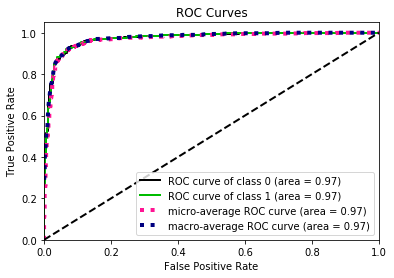

In [58]:
y_probas =  clf_SVC_best.predict_proba(X_test_scaled) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

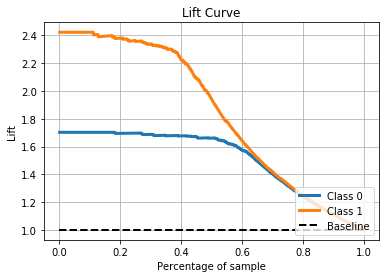

In [59]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## Random Forest

In [60]:
start = time.process_time()
RF = ensemble.RandomForestClassifier()

# Hyper parameter tuning using GridSearch
param_set ={'max_depth': [3,10,20],
            'min_samples_split' :[4, 5,10],
            'n_estimators': [100, 250,500],
            'bootstrap':[True, False] ,
            'max_features':['auto', 'sqrt'],
            'n_jobs': [-1]
           }
grid_RF = GridSearchCV(RF, param_grid = param_set, cv=5, scoring='precision')
grid_RF.fit(X_train,y_train)

# examine the best model
print("Best score achieved across all parameters: ", grid_RF.best_score_)

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_RF.best_params_)

print(" ")
print("Best estimator")
print (grid_RF.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_RF_best = grid_RF.best_estimator_
scores = cross_val_score(clf_RF_best, X_train, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Check performance on test data
clf_RF_best.fit(X_train,y_train)
print(" ")
y_pred = clf_RF_best.predict(X_test_holdout)
print("Random Forest : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("Random Forest : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("Random Forest : Classification Report")
print(classification_report(y_test_holdout, y_pred))

print(" ")
print('Time Taken = ', time.process_time() - start)

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Best score achieved across all parameters:  0.9549746603508357
 
Best parameters
{'bootstrap': False, 'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 4, 'n_estimators': 250, 'n_jobs': -1}
 
Best estimator
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
 
cross-validation results
Below are the scores for each model run
[0.89435601 0.90593343 0.8942029  0.91872279 0.91582003]
 
Mean Accuracy and variance: 0.91 (+/- 0.02)
 
Random Forest : accuracy on test data is  90.44 %
 
Random Forest : Confusion Matrix
 
[[667   9]
 [101 374]]
 
Random Forest : Classification Report
              precision    recall  f1-s

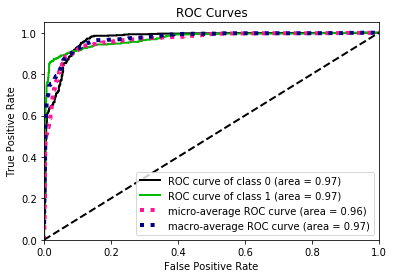

In [61]:
y_probas =  clf_RF_best.predict_proba(X_test_holdout) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

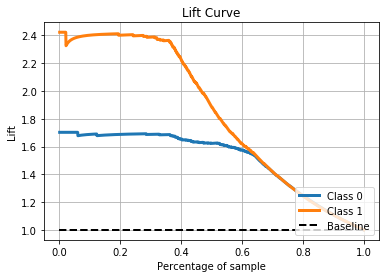

In [62]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## XGBoost

In [95]:
start = time.process_time()
XGB = xgboost.XGBClassifier(nthreads=-1)

a = stat.beta(10, 1)

# Hyper parameter tuning using GridSearch
param_set ={"n_estimators": stat.randint(3, 40),
            "max_depth": stat.randint(3, 40),
            "learning_rate": stat.uniform(0.05, 0.4),
            "colsample_bytree": a,
            "subsample": a,
            "gamma": st.uniform(0, 10),
            'n_jobs':[-1]
           }

grid_XGB = RandomizedSearchCV(XGB, param_set, cv=5, scoring='precision')
grid_XGB.fit(X_train,y_train)

# examine the best model
print("Best score achieved across all parameters: ", abs(grid_XGB.best_score_))

# Dictionary containing the parameters used to generate that score
print(" ")
print("Best parameters")
print (grid_XGB.best_params_)

print(" ")
print("Best estimator")
print (grid_XGB.best_estimator_)

#cross-validation
print(" ")
print("cross-validation results")
clf_XGB_best = grid_XGB.best_estimator_
scores = cross_val_score(clf_XGB_best, X_train, y_train, cv=5)

print("Below are the scores for each model run")
print(scores)

print(" ")
print("Mean Accuracy and variance: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Check performance on test data
clf_XGB_best.fit(X_train,y_train)
print(" ")
y_pred = clf_XGB_best.predict(X_test_holdout)
print("XGBoost : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("XGBoost : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("XGBoost : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

print('Time Taken = ', time.process_time() - start)

Best score achieved across all parameters:  0.9426408918035691
 
Best parameters
{'colsample_bytree': 0.7657300887344023, 'gamma': 6.311515151642714, 'learning_rate': 0.4396348342054399, 'max_depth': 38, 'n_estimators': 38, 'n_jobs': -1, 'subsample': 0.8603134677260298}
 
Best estimator
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7657300887344023,
       gamma=6.311515151642714, learning_rate=0.4396348342054399,
       max_delta_step=0, max_depth=38, min_child_weight=1, missing=None,
       n_estimators=38, n_jobs=-1, nthread=None, nthreads=-1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=0.8603134677260298, verbosity=1)
 
cross-validation results
Below are the scores for each model run
[0.94934877 0.94645441 0.94347826 0.9521045  0.94339623]
 
Mean Accuracy and variance: 0.95 (+/- 0.01)
 
XGBoost : accuracy on test

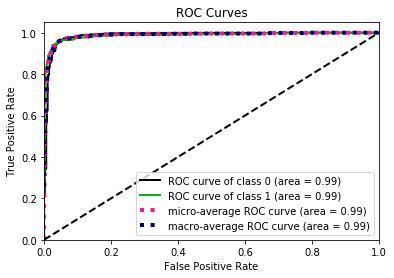

In [96]:
y_probas =  clf_XGB_best.predict_proba(X_test_holdout) # predicted probabilities generated by classifier
sckplt.metrics.plot_roc_curve(y_test_holdout, y_probas)
plt.show()

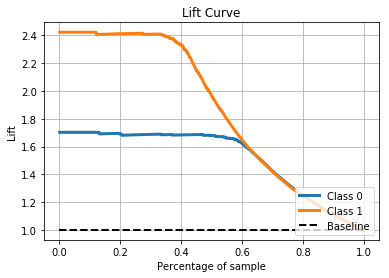

In [97]:
sckplt.metrics.plot_lift_curve(y_test_holdout, y_probas)
plt.show()

## Neural Network

##### Shallow Network

In [63]:
NN = Sequential()
# n_cols = x_train.shape[1]
NN.add(Dense(114, activation = 'relu', input_dim=57))
NN.add(Dense(1,activation = 'sigmoid'))
NN.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

NN.fit(X_train,y_train,batch_size=40,epochs=100)

accuracy = NN.evaluate(X_test_holdout, y_test_holdout)
print(accuracy)

Epoch 1/100
3450/3450 [==============================] - 0s 124us/step - loss: 1.1268 - accuracy: 0.7043
Epoch 2/100
3450/3450 [==============================] - 0s 51us/step - loss: 0.3866 - accuracy: 0.8777
Epoch 3/100
3450/3450 [==============================] - 0s 58us/step - loss: 0.4330 - accuracy: 0.8614
Epoch 4/100
3450/3450 [==============================] - 0s 51us/step - loss: 0.4346 - accuracy: 0.8759
Epoch 5/100
3450/3450 [==============================] - 0s 32us/step - loss: 0.4584 - accuracy: 0.8687
Epoch 6/100
3450/3450 [==============================] - 0s 57us/step - loss: 0.3826 - accuracy: 0.8812
Epoch 7/100
3450/3450 [==============================] - 0s 60us/step - loss: 0.3034 - accuracy: 0.9026
Epoch 8/100
3450/3450 [==============================] - 0s 39us/step - loss: 0.2786 - accuracy: 0.9096
Epoch 9/100
3450/3450 [==============================] - 0s 47us/step - loss: 0.2807 - accuracy: 0.9081
Epoch 10/100
3450/3450 [==============================] - 0s 40

3450/3450 [==============================] - 0s 51us/step - loss: 0.2338 - accuracy: 0.9388
Epoch 79/100
3450/3450 [==============================] - 0s 61us/step - loss: 0.1662 - accuracy: 0.9519
Epoch 80/100
3450/3450 [==============================] - 0s 47us/step - loss: 0.1637 - accuracy: 0.9513
Epoch 81/100
3450/3450 [==============================] - 0s 58us/step - loss: 0.4888 - accuracy: 0.9049
Epoch 82/100
3450/3450 [==============================] - 0s 60us/step - loss: 0.2640 - accuracy: 0.9316
Epoch 83/100
3450/3450 [==============================] - 0s 57us/step - loss: 0.2622 - accuracy: 0.9359
Epoch 84/100
3450/3450 [==============================] - 0s 60us/step - loss: 0.2198 - accuracy: 0.9435
Epoch 85/100
3450/3450 [==============================] - 0s 59us/step - loss: 0.1884 - accuracy: 0.9510
Epoch 86/100
3450/3450 [==============================] - 0s 54us/step - loss: 0.2268 - accuracy: 0.9461
Epoch 87/100
3450/3450 [==============================] - 0s 51us/st

In [64]:
# Predicting the Test set results
y_pred = NN.predict(X_test_holdout)
y_pred = (y_pred > 0.5)

print("Neural Network : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("Neural Network : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("Neural Network : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Neural Network : accuracy on test data is  93.92 %
 
Neural Network : Confusion Matrix
 
[[635  41]
 [ 29 446]]
 
Neural Network : Classification Report
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       676
           1       0.92      0.94      0.93       475

   micro avg       0.94      0.94      0.94      1151
   macro avg       0.94      0.94      0.94      1151
weighted avg       0.94      0.94      0.94      1151

Average Misclassification cost on test data is  439


##### Medium Deep Network

In [65]:
NN = Sequential()
# n_cols = x_train.shape[1]
NN.add(Dense(57, activation = 'relu', input_dim=57))
NN.add(Dense(57, activation = 'relu'))
NN.add(Dense(1,activation = 'sigmoid'))
NN.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

NN.fit(X_train,y_train,batch_size=40,epochs=100)

accuracy = NN.evaluate(X_test_holdout, y_test_holdout)
print(accuracy)

Epoch 1/100
3450/3450 [==============================] - 0s 135us/step - loss: 0.8202 - accuracy: 0.7110
Epoch 2/100
3450/3450 [==============================] - 0s 32us/step - loss: 0.8922 - accuracy: 0.7910
Epoch 3/100
3450/3450 [==============================] - 0s 34us/step - loss: 0.5591 - accuracy: 0.8499
Epoch 4/100
3450/3450 [==============================] - 0s 53us/step - loss: 0.4249 - accuracy: 0.8762
Epoch 5/100
3450/3450 [==============================] - 0s 34us/step - loss: 0.3108 - accuracy: 0.8983
Epoch 6/100
3450/3450 [==============================] - 0s 62us/step - loss: 0.4360 - accuracy: 0.8725
Epoch 7/100
3450/3450 [==============================] - 0s 52us/step - loss: 0.4062 - accuracy: 0.8794
Epoch 8/100
3450/3450 [==============================] - 0s 33us/step - loss: 0.3479 - accuracy: 0.8922
Epoch 9/100
3450/3450 [==============================] - 0s 63us/step - loss: 0.3237 - accuracy: 0.8986
Epoch 10/100
3450/3450 [==============================] - 0s 47

3450/3450 [==============================] - 0s 49us/step - loss: 0.1498 - accuracy: 0.9548
Epoch 79/100
3450/3450 [==============================] - 0s 48us/step - loss: 0.1679 - accuracy: 0.9510 0s - loss: 0.1912 - accuracy: 0.
Epoch 80/100
3450/3450 [==============================] - 0s 41us/step - loss: 0.1565 - accuracy: 0.9470
Epoch 81/100
3450/3450 [==============================] - 0s 42us/step - loss: 0.1491 - accuracy: 0.9548
Epoch 82/100
3450/3450 [==============================] - 0s 55us/step - loss: 0.1482 - accuracy: 0.9533
Epoch 83/100
3450/3450 [==============================] - 0s 54us/step - loss: 0.1698 - accuracy: 0.9475
Epoch 84/100
3450/3450 [==============================] - 0s 61us/step - loss: 0.2193 - accuracy: 0.9394
Epoch 85/100
3450/3450 [==============================] - 0s 45us/step - loss: 0.1806 - accuracy: 0.9464
Epoch 86/100
3450/3450 [==============================] - 0s 62us/step - loss: 0.1844 - accuracy: 0.9490
Epoch 87/100
3450/3450 [===========

In [66]:
# Predicting the Test set results
y_pred = NN.predict(X_test_holdout)
y_pred = (y_pred > 0.5)

print("Neural Network : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("Neural Network : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("Neural Network : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Neural Network : accuracy on test data is  93.74 %
 
Neural Network : Confusion Matrix
 
[[649  27]
 [ 45 430]]
 
Neural Network : Classification Report
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       676
           1       0.94      0.91      0.92       475

   micro avg       0.94      0.94      0.94      1151
   macro avg       0.94      0.93      0.94      1151
weighted avg       0.94      0.94      0.94      1151

Average Misclassification cost on test data is  315


##### Deep Network

In [67]:
NN = Sequential()
# n_cols = x_train.shape[1]
NN.add(Dense(25, activation = 'relu', input_dim=57))
NN.add(Dense(25, activation = 'relu'))
NN.add(Dense(25, activation = 'relu'))
NN.add(Dense(1,activation = 'sigmoid'))
NN.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

NN.fit(X_train,y_train,batch_size=40,epochs=100)

accuracy = NN.evaluate(X_test_holdout, y_test_holdout)
print(accuracy)

Epoch 1/100
3450/3450 [==============================] - 1s 166us/step - loss: 1.0375 - accuracy: 0.6672
Epoch 2/100
3450/3450 [==============================] - 0s 35us/step - loss: 0.6374 - accuracy: 0.8061
Epoch 3/100
3450/3450 [==============================] - 0s 43us/step - loss: 0.3927 - accuracy: 0.8658
Epoch 4/100
3450/3450 [==============================] - 0s 68us/step - loss: 0.4796 - accuracy: 0.8472
Epoch 5/100
3450/3450 [==============================] - 0s 39us/step - loss: 0.4572 - accuracy: 0.8629
Epoch 6/100
3450/3450 [==============================] - 0s 38us/step - loss: 0.4104 - accuracy: 0.8765
Epoch 7/100
3450/3450 [==============================] - 0s 37us/step - loss: 0.2791 - accuracy: 0.9020
Epoch 8/100
3450/3450 [==============================] - 0s 40us/step - loss: 0.2851 - accuracy: 0.9078
Epoch 9/100
3450/3450 [==============================] - 0s 36us/step - loss: 0.4492 - accuracy: 0.8707
Epoch 10/100
3450/3450 [==============================] - 0s 52

3450/3450 [==============================] - 0s 40us/step - loss: 0.1554 - accuracy: 0.9435
Epoch 80/100
3450/3450 [==============================] - 0s 65us/step - loss: 0.1966 - accuracy: 0.9359
Epoch 81/100
3450/3450 [==============================] - 0s 67us/step - loss: 0.1754 - accuracy: 0.9391
Epoch 82/100
3450/3450 [==============================] - 0s 58us/step - loss: 0.1687 - accuracy: 0.9423
Epoch 83/100
3450/3450 [==============================] - 0s 64us/step - loss: 0.1698 - accuracy: 0.9388
Epoch 84/100
3450/3450 [==============================] - 0s 66us/step - loss: 0.1711 - accuracy: 0.9394
Epoch 85/100
3450/3450 [==============================] - 0s 64us/step - loss: 0.1761 - accuracy: 0.9420
Epoch 86/100
3450/3450 [==============================] - 0s 63us/step - loss: 0.1747 - accuracy: 0.9417
Epoch 87/100
3450/3450 [==============================] - 0s 50us/step - loss: 0.2277 - accuracy: 0.9359
Epoch 88/100
3450/3450 [==============================] - 0s 38us/st

In [68]:
# Predicting the Test set results
y_pred = NN.predict(X_test_holdout)
y_pred = (y_pred > 0.5)

print("Neural Network : accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
print("Neural Network : Confusion Matrix")
print(" ")
print(confusion_matrix(y_test_holdout, y_pred))
print(" ")
print("Neural Network : Classification Report")
print(classification_report(y_test_holdout, y_pred))

cfm = confusion_matrix(y_test_holdout, y_pred)
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

Neural Network : accuracy on test data is  91.23 %
 
Neural Network : Confusion Matrix
 
[[600  76]
 [ 25 450]]
 
Neural Network : Classification Report
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       676
           1       0.86      0.95      0.90       475

   micro avg       0.91      0.91      0.91      1151
   macro avg       0.91      0.92      0.91      1151
weighted avg       0.92      0.91      0.91      1151

Average Misclassification cost on test data is  785


In [ ]:
# Creating the custom cost function for scoring

#from sklearn.metrics import fbeta_score, make_scorer

#def custom_loss_func(y_true, y_pred):
#    d1 = (y_true - y_pred).sum() * 10
#    diff2 = (y_pred - y_true).sum() * 1
#    return d1 + diff2

# score_function = make_scorer(custom_loss_func, greater_is_better=True)

#Creating a function to calculate average misclassification cost

clf_DTree = tree.DecisionTreeClassifier()
print(" ")
print("Model Optimized for accuracy")
# Hyper parameter tuning using GridSearch
param_set ={'max_depth': range(3,15), 'min_samples_split' : range(3,10), 'criterion' : ["gini", "entropy"]}
grid_DTree = GridSearchCV(clf_DTree, param_grid = param_set, cv=5, scoring='accuracy')
grid_DTree.fit(X_train_scaled,y_train)

clf_Dtree_best = grid_DTree.best_estimator_
scores = cross_val_score(clf_Dtree_best, X_train, y_train, cv=5)
print(" ")
print("Mean Accuracy on Training data: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#prediction on test data
clf_Dtree_best.fit(X_train,y_train)
print(" ")
y_pred = clf_Dtree_best.predict(X_test_holdout)
print("Accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
cfm = confusion_matrix(y_test_holdout, y_pred)
print(" ")
print("Confusion Matrix")
print(cfm)
print(" ")
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

print(" ")
print("Model Optimized for precision")
# Hyper parameter tuning using GridSearch
param_set ={'max_depth': range(3,15), 'min_samples_split' : range(3,10), 'criterion' : ["gini", "entropy"]}
grid_DTree = GridSearchCV(clf_DTree, param_grid = param_set, cv=5, scoring='accuracy')
grid_DTree.fit(X_train_scaled,y_train)

clf_Dtree_best = grid_DTree.best_estimator_
scores = cross_val_score(clf_Dtree_best, X_train, y_train, cv=5)
print(" ")
print("Mean Precision on Training data: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#prediction on test data
clf_Dtree_best.fit(X_train,y_train)
print(" ")
y_pred = clf_Dtree_best.predict(X_test_holdout)
print("Accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
cfm = confusion_matrix(y_test_holdout, y_pred)
print(" ")
print("Confusion Matrix")
print(cfm)
print(" ")
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))

print(" ")
print("Model Optimized for weighted precision using custom function")
# Hyper parameter tuning using GridSearch
param_set ={'max_depth': range(3,15), 'min_samples_split' : range(3,10), 'criterion' : ["gini", "entropy"]}
grid_DTree = GridSearchCV(clf_DTree, param_grid = param_set, cv=5, scoring=score_function)
grid_DTree.fit(X_train_scaled,y_train)

clf_Dtree_best = grid_DTree.best_estimator_
scores = cross_val_score(clf_Dtree_best, X_train, y_train, cv=5)
print(" ")
print("Mean score on Training data: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#prediction on test data
clf_Dtree_best.fit(X_train,y_train)
print(" ")
y_pred = clf_Dtree_best.predict(X_test_holdout)
print("Accuracy on test data is ",round(accuracy_score(y_test_holdout, y_pred)*100,2),"%")
print(" ")
cfm = confusion_matrix(y_test_holdout, y_pred)
print(" ")
print("Confusion Matrix")
print(cfm)
print(" ")
print("Average Misclassification cost on test data is ",(calc_cost(cfm,cost)))